# Исследование о продажах игр

Из открытых источников доступны исторические данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

Цедь проекта — выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые помогут спрогназировать продажи на 2017 год.

Для выполнения цели нам нужно:
- изучть общую информацию
- выполнить предобработку данных
- провести исследовательский анализ
- составить портрет пользователя
- проверить гипотезы

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')
pd.set_option('display.max_columns', None)

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Изучив общую информацию видно, что в данных есть пропуски, которые нужно будет обработать; по правилам хорошего стиля привести названия столбцов к нижнему регистру; в столбце **Year_of_Release** очевидно поменять тип данных на **int**; разобраться почему в столбце **User_Score** тип данных **object** и поменять на **float**.

### Подготовка данных

#### Приведем названия столбцов к нижнему регистру.

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Обработаем пропуски

In [7]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Удалим пропущенные значения в столбцах **name, year_of_release, genre**, т.к. их доля мала и они не на что не повлияют.

In [9]:
df = df.dropna(subset=['name', 'year_of_release', 'genre']).reset_index(drop=True)

Можно заменить пропуски в столбцес рейтингом на **no_rating**.

In [10]:
df['rating'] = df['rating'].fillna('no_rating')
df['rating'].value_counts()

no_rating    6676
E            3921
T            2905
M            1536
E10+         1393
EC              8
K-A             3
AO              1
RP              1
Name: rating, dtype: int64

Пропуски могли появится из-за невнимательности человека, вносившего данные, так же просто из-за отсутствия этих данных, как например в оценке критиков и пользлвателей.

In [11]:
df['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.9       2
0.5       2
0.2       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [12]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

В столбце с оценкой пользователей наблюдаются значения **tbd** - оценка не определена, необходимо заменить его на **nan**, чтобы провести корректный анализ.

Проверим датафрейм на наличие дубликатов.

In [13]:
print('Количестов явных дубликатов:', df.duplicated().sum())

Количестов явных дубликатов: 0


#### Преобразуем данные в нужный тип

После обработки пропусков изменим тип данных в столбце **year_of_release** на **int** и в столбце **user_score** на **float**.

In [14]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['user_score'] = df['user_score'].astype('float')

#### Посчитаем суммарные продажи во всех регионах

Добавим новый столбец **all_sales** с суммарными продажами.

In [15]:
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [16]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no_rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no_rating,31.38


При предобработке данных были переведены названия столбцов к нижнему регистру, обработаны пропуски: удалили строки, где количество пропусков было не значительным; заменили пропуски в столбце с рейтингом для корректной работы в дальнейшем. В столбце с оценкой пользователей избавились от значения **tbd**, для того чтобы изменить тип столбца на **float**. Так же изменили тип данных у столбца с годом релиза, потому что логично что номер года это целое число. Проверили датафрейм на явные дубликаты, которые не обнаружились.

### Исследовательский анализ данных

#### Посмотрим сколько игр выпускалось в разные годы

In [17]:
np.sort(df['year_of_release'].unique())

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

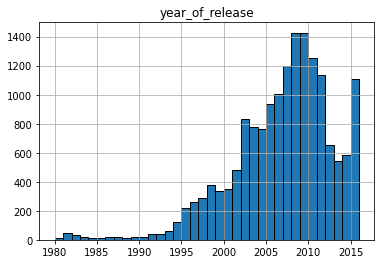

In [18]:
bins = [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016]
df.hist('year_of_release', bins=bins, edgecolor="black");
df['year_of_release'].describe()

По гистограмме мы видим, что количество выпущенных игр активно росло с 1995 года, из этого можно сказать что данные до 94-ого не так важны. Рост создания игр можно связать с выпуском игровых консолей и развитием игровой индустрии.

#### Посмотрите, как менялись продажи по платформам

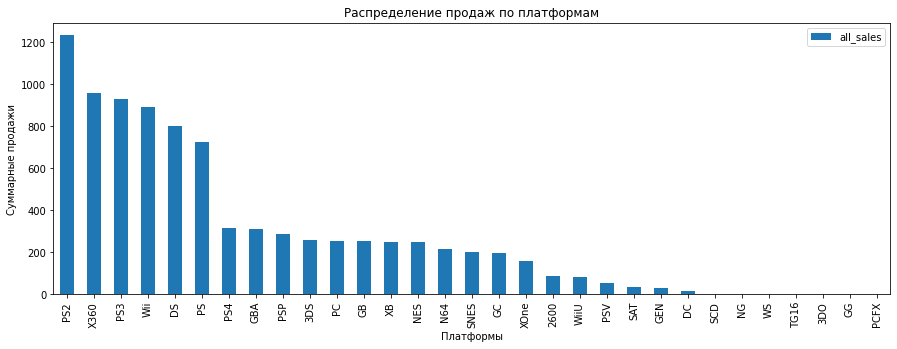

In [19]:
platform_distribution = df.pivot_table(
    index='platform', 
    values='all_sales', 
    aggfunc='sum').sort_values(by = 'all_sales', ascending=False)
platform_distribution.plot(
    kind='bar', 
    title='Распределение продаж по платформам', 
    figsize=(15, 5));
plt.xlabel('Платформы');
plt.ylabel('Суммарные продажи');

Наибольшие суммарные продажи у первых 6 платформ (**PS2, X360, PS3, Wii, DS, PS**), по ним и будем смотреть распределение по годам.

In [20]:
top_6 = platform_distribution.iloc[:6].reset_index()
top_6

,platform,all_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58


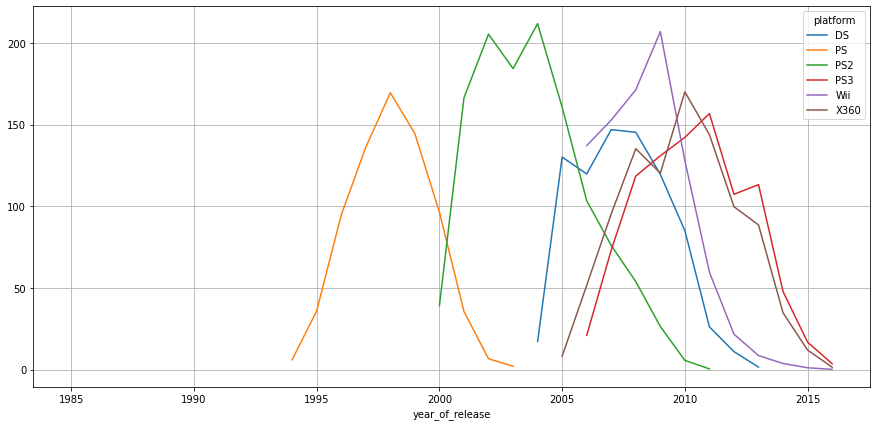

In [21]:
platform_totalsales = df.pivot_table(index='platform', values='all_sales', aggfunc='sum').nlargest(6, 'all_sales').index
df.query('platform in @platform_totalsales').pivot_table(
    index = 'year_of_release', 
    columns = 'platform', 
    values= 'all_sales', 
    aggfunc = 'sum').plot(figsize = (15,7))
plt.grid()
plt.show()

Платформа  PS2
                          all_sales
platform year_of_release           
PS2      2000                 39.17
         2001                166.43
         2002                205.38
         2003                184.31
         2004                211.81
         2005                160.66
         2006                103.42
         2007                 75.99
         2008                 53.90
         2009                 26.40
         2010                  5.64
         2011                  0.45

Платформа  X360
                          all_sales
platform year_of_release           
X360     2005                  8.25
         2006                 51.62
         2007                 95.41
         2008                135.26
         2009                120.29
         2010                170.03
         2011                143.84
         2012                 99.74
         2013                 88.58
         2014                 34.74
         2015                 11

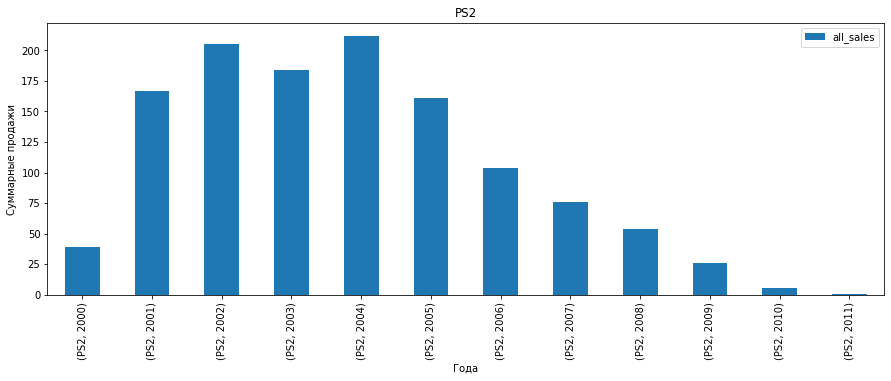

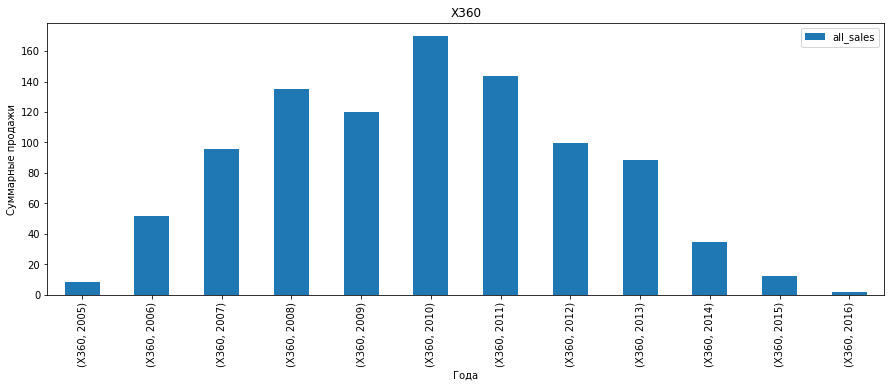

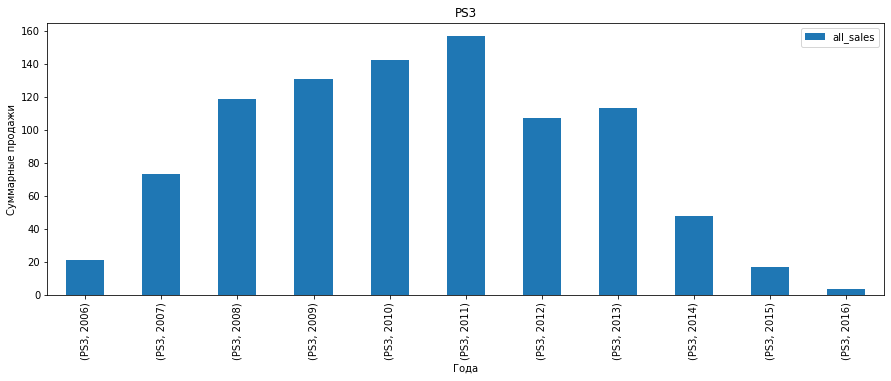

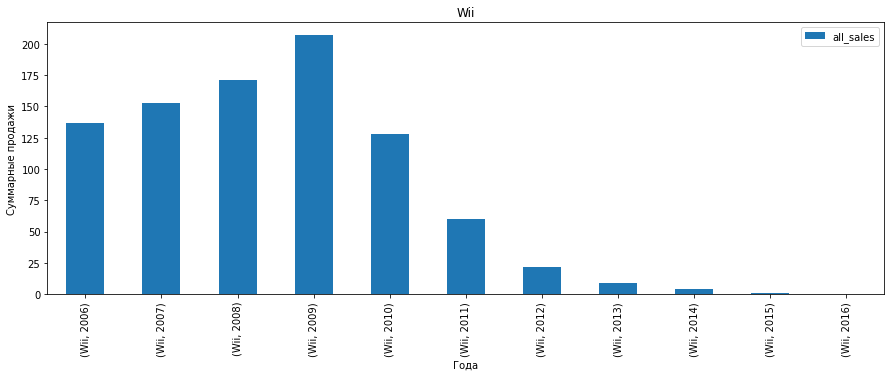

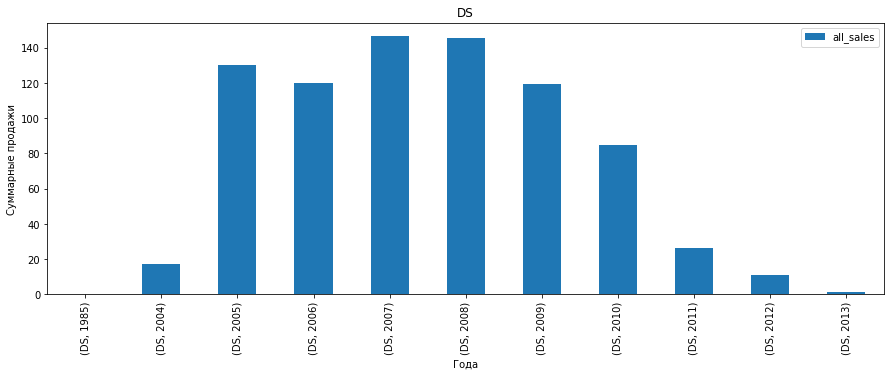

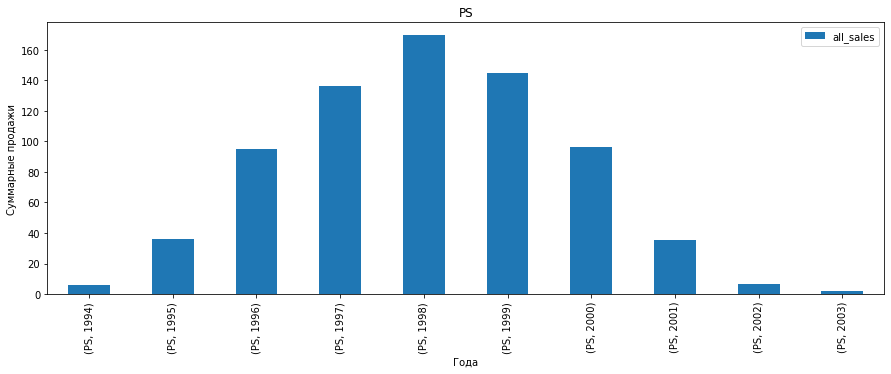

In [22]:
for platform in platform_totalsales:
    print('Платформа ',platform)
    platform_sales = pd.pivot_table(df.query('platform == @platform'), 
                                    index=['platform','year_of_release'], values='all_sales', aggfunc='sum')
    platform_sales.plot(kind='bar', title=platform, figsize=(15, 5));
    plt.xlabel('Года');
    plt.ylabel('Суммарные продажи');
    print(platform_sales)
    print()

Судя по распределению платформы работают 9-11 лет, с появлением новых игровых приставок и улучшением технологий появляются и новые более усовершенствованные платформы.

#### Определим актуальный период

Отдельно посмотрим на **PS4**.

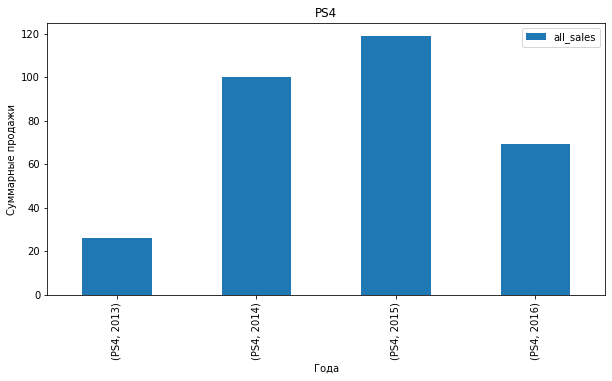

In [23]:
df[df['platform'] == 'PS4'].pivot_table(index=['platform','year_of_release'], 
                                        values='all_sales', aggfunc='sum').plot(kind='bar', title="PS4", figsize=(10, 5));
plt.xlabel('Года');
plt.ylabel('Суммарные продажи');

Так как сама консоль вышла только в 2013 году, суммарные продажи на 2016 пока маленькие, но она проработает еще лет 6 и нужно учитывать её в дальнейшем анализе.

Возьмём актуальный период с 2014 по 2016 год.

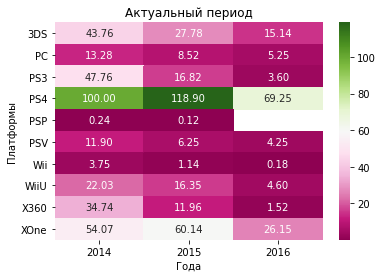

In [24]:
topical_period = df.query('year_of_release > 2013')
topical_period_pivot = topical_period.pivot_table(index='platform', 
                                                  columns='year_of_release', values='all_sales', aggfunc='sum')
sns.heatmap(topical_period_pivot, annot=True, cmap="PiYG", fmt='.2f');
plt.title('Актуальный период');
plt.xlabel('Года');
plt.ylabel('Платформы');

#### Даннные до 2014 года больше не учитываем

In [25]:
topical_period.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,no_rating,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,no_rating,7.98


#### Выберем несколько потенциально прибыльных платформ

In [26]:
topical_period.pivot_table(
    index='platform', 
    values='all_sales', 
    aggfunc='sum').sort_values(by = 'all_sales', ascending=False)

,all_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


За актуальный период мы видим, что лидируют по продажам 5 платформ (**PS4, XOne, 3DS, PS3, X360**). С выходом **PS4** и **XOne** продажи на **PS3** и **X360** начали падать, так как первые заменяют предыдущее поколение приставок и соответсвенно продажи у них растут. 

#### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам

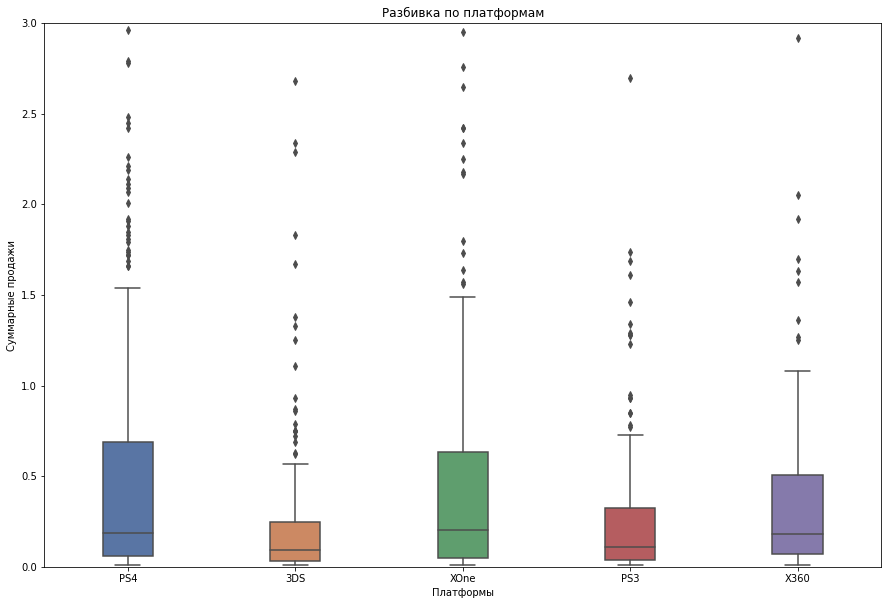

In [27]:
plt.subplots(figsize=(15, 10))
sns.set(style='darkgrid')
top_topical_period = topical_period.query('platform == ["PS4", "XOne", "3DS", "PS3", "X360"]')
sns.boxplot(x=top_topical_period['platform'], y=top_topical_period['all_sales'], width=0.3)
plt.ylim(0, 3);
plt.title('Разбивка по платформам');
plt.ylabel('Суммарные продажи');
plt.xlabel('Платформы');

In [28]:
topical_period.query('platform == ["PS4", "PS3", "XOne", "3DS", "X360"]').groupby('platform')['all_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


На графиках мы видим выбросы, это более популярные игры которые хорошо продаются. Так же видно что большинство значений больше медианного и треть игр по каждой платфоре продаются меньше чем за 800 тыс. Можно предположить что создатели акцентируют больше внимания на меньшем колличестве игр, делая их более качественными и в последствии именно они приносят больший доход. 

#### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

In [29]:
PS4 = topical_period.query('platform == "PS4"')
PS4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,no_rating,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66


,critic_score,user_score,all_sales
critic_score,1.000000,0.546434,0.402661
user_score,0.546434,1.000000,-0.040132
all_sales,0.402661,-0.040132,1.000000


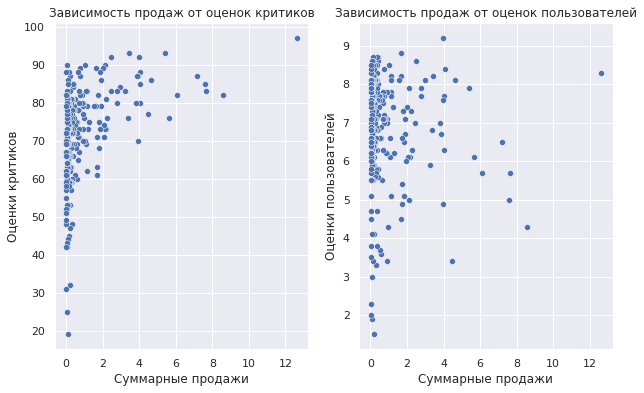

In [30]:
plt.subplots(figsize=(10, 6))
plt.subplot(121)
sns.scatterplot(data=PS4, x='all_sales', y='critic_score');
plt.title('Зависимость продаж от оценок критиков');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки критиков');
plt.subplot(122)
sns.scatterplot(data=PS4, x='all_sales', y='user_score');
plt.title('Зависимость продаж от оценок пользователей');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки пользователей');
PS4_cor = PS4[['critic_score', 'user_score', 'all_sales']]
PS4_cor.corr()

Посчитав корреляцию между отзывами и продажами для платформы **PS4**, мы видим что продажи игр зависят от оценки критиков, а вот зависимости от оценки игров нет.  

Так же следует заметить зависимость оценок игроков от оценок критиков.

#### Продажи игр на других платформах

In [31]:
#PS3_XOne_3DS_X360 = topical_period.query('platform == ["PS3", "XOne", "3DS", "X360"]')
#PS3_XOne_3DS_X360.head()

Платформа PS3


,critic_score,user_score,all_sales
critic_score,1.000000,0.693445,0.446575
user_score,0.693445,1.000000,-0.166761
all_sales,0.446575,-0.166761,1.000000


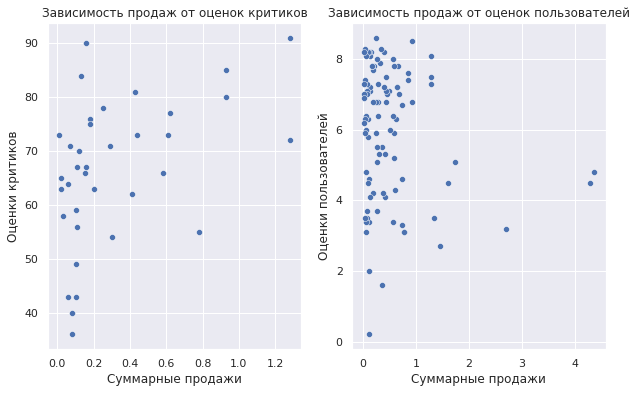

In [32]:
PS3 = topical_period.query('platform == "PS3"')
print('Платформа PS3')
plt.subplots(figsize=(10, 6))
plt.subplot(121)
sns.scatterplot(data=PS3, x='all_sales', y='critic_score');
plt.title('Зависимость продаж от оценок критиков');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки критиков');
plt.subplot(122)
sns.scatterplot(data=PS3, x='all_sales', y='user_score');
plt.title('Зависимость продаж от оценок пользователей');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки пользователей');
PS3_cor = PS3[['critic_score', 'user_score', 'all_sales']]
PS3_cor.corr()

Платформа XOne


,critic_score,user_score,all_sales
critic_score,1.000000,0.440977,0.428677
user_score,0.440977,1.000000,-0.070384
all_sales,0.428677,-0.070384,1.000000


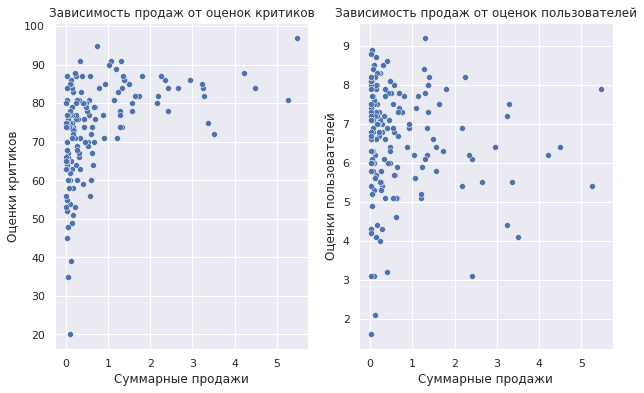

In [33]:
XOne = topical_period.query('platform == "XOne"')
print('Платформа XOne')
plt.subplots(figsize=(10, 6))
plt.subplot(121)
sns.scatterplot(data=XOne, x='all_sales', y='critic_score');
plt.title('Зависимость продаж от оценок критиков');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки критиков');
plt.subplot(122)
sns.scatterplot(data=XOne, x='all_sales', y='user_score');
plt.title('Зависимость продаж от оценок пользователей');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки пользователей');
XOne_cor = XOne[['critic_score', 'user_score', 'all_sales']]
XOne_cor.corr()

Платформа 3DS


,critic_score,user_score,all_sales
critic_score,1.000000,0.862485,0.314117
user_score,0.862485,1.000000,0.215193
all_sales,0.314117,0.215193,1.000000


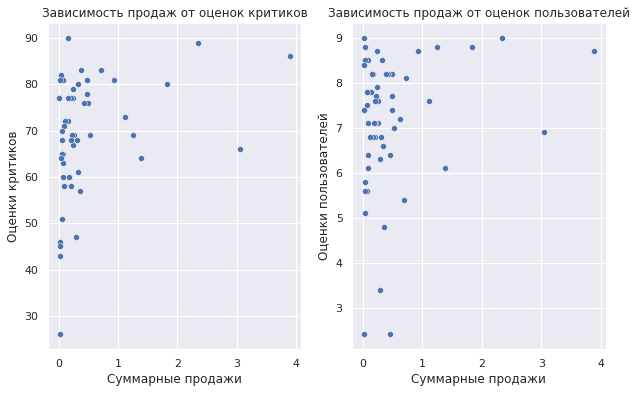

In [34]:
_3DS = topical_period.query('platform == "3DS"')
print('Платформа 3DS')
plt.subplots(figsize=(10, 6))
plt.subplot(121)
sns.scatterplot(data=_3DS, x='all_sales', y='critic_score');
plt.title('Зависимость продаж от оценок критиков');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки критиков');
plt.subplot(122)
sns.scatterplot(data=_3DS, x='all_sales', y='user_score');
plt.title('Зависимость продаж от оценок пользователей');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки пользователей');
_3DS_cor = _3DS[['critic_score', 'user_score', 'all_sales']]
_3DS_cor.corr()

Платформа X360


,critic_score,user_score,all_sales
critic_score,1.000000,0.625309,0.525723
user_score,0.625309,1.000000,-0.138445
all_sales,0.525723,-0.138445,1.000000


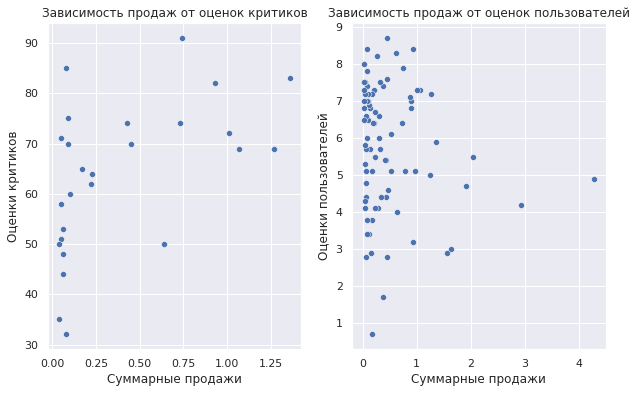

In [35]:
X360 = topical_period.query('platform == "X360"')
print('Платформа X360')
plt.subplots(figsize=(10, 6))
plt.subplot(121)
sns.scatterplot(data=X360, x='all_sales', y='critic_score');
plt.title('Зависимость продаж от оценок критиков');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки критиков');
plt.subplot(122)
sns.scatterplot(data=X360, x='all_sales', y='user_score');
plt.title('Зависимость продаж от оценок пользователей');
plt.xlabel('Суммарные продажи');
plt.ylabel('Оценки пользователей');
X360_cor = X360[['critic_score', 'user_score', 'all_sales']]
X360_cor.corr()

На платформах **PS3, XOne, X360** ситуация такая же как и на **PS4**, прослеживается прямая зависимость продаж от оценок критиков. На платформе **3DS** прямая зависимость как от оценок критиков, так и от оценок игроков, хоть она и не велика. 

На всех 4 платформах так же есть прямая зависимость оценок игроков от оценок критиков.

#### Распределение игр по жанру

,all_sales
genre,
Action,199.36
Shooter,170.94
Sports,109.48
Role-Playing,101.44
Misc,37.55
Fighting,28.22
Racing,27.52
Platform,18.09
Adventure,17.55


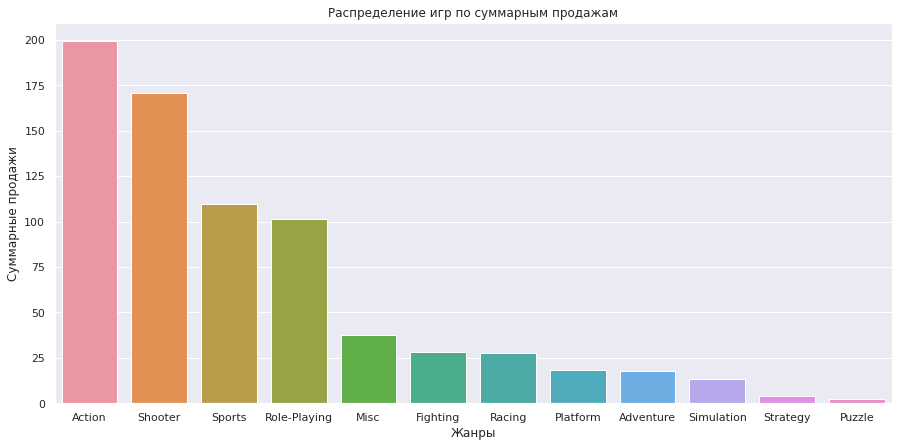

In [36]:
plt.subplots(figsize=(15, 7))
genre_table = topical_period.pivot_table(
    index='genre', values='all_sales', aggfunc='sum').sort_values(
    by='all_sales', ascending=False)
sns.barplot(x=genre_table.index, y=genre_table['all_sales']);
plt.title('Распределение игр по суммарным продажам');
plt.ylabel('Суммарные продажи');
plt.xlabel('Жанры');
genre_table

,all_sales
genre,
Shooter,1.335469
Sports,0.680000
Platform,0.476053
Fighting,0.470333
Role-Playing,0.459005
Racing,0.398841
Misc,0.332301
Action,0.322068
Simulation,0.298409


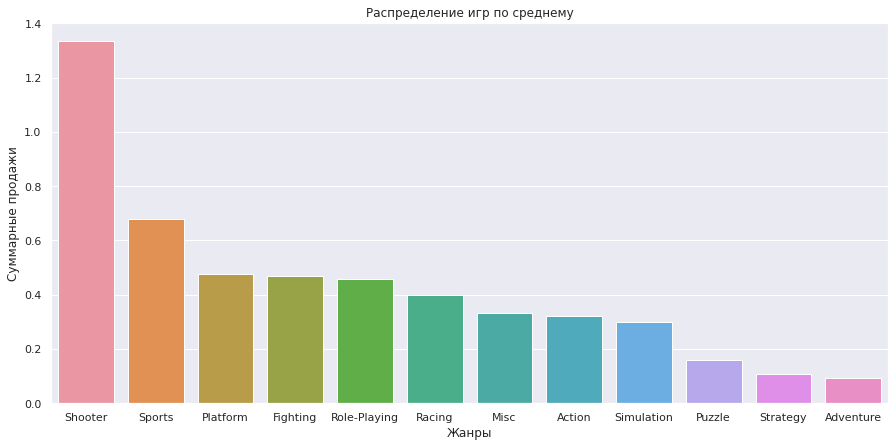

In [37]:
plt.subplots(figsize=(15, 7))
genre_table = topical_period.pivot_table(
    index='genre', values='all_sales', aggfunc='mean').sort_values(
    by='all_sales', ascending=False)
sns.barplot(x=genre_table.index, y=genre_table['all_sales']);
plt.title('Распределение игр по среднему');
plt.ylabel('Суммарные продажи');
plt.xlabel('Жанры');
genre_table

Если смотреть распределение по суммарным продажам то самыми прибыльными жанрами будут экшен, шутеры, спортивные и ролевые игры. Если же смотреть по среднему значению продаж, в таком случае лидеры остаются теже за исключением экшена, скорее всего по суммарным продажам этот жанр опережает из-за популярности нескольких конкретных игр, которые и принесли большой доход. Можно сделать такой вывод, что самыми продоваемыми играми остаются шутеры, спортивные и ролевые. Самые низкие продажи у игр жанров пазлы, стратегия, приключения и симуляторы.  

**Общий вывод по разделу**

Проведя анализ мы установили актуальный период с 2013 по 2016 год, благодаря чему мы узнали какие платформы остаются самыми прибыльными и дальше будут продолжать работать, а именно это **PS4, XOne, 3DS**. Так же мы выяснили что оценка критиков влияет на рейтинги и от них на прямую зависит продоваемость игр. Были определены какого жанра игры являются самыми прибыльными.

### Портрет пользователя каждого региона

#### Самые популярные платформы 

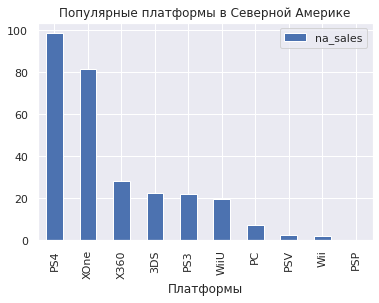

In [38]:
topical_period.pivot_table(
    index='platform', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales',ascending=False).plot(kind='bar');
plt.title('Популярные платформы в Северной Америке');
plt.xlabel('Платформы');

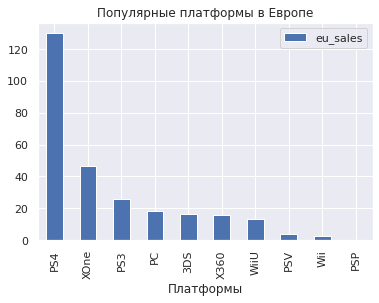

In [39]:
topical_period.pivot_table(
    index='platform', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales',ascending=False).plot(kind='bar');
plt.title('Популярные платформы в Европе');
plt.xlabel('Платформы');

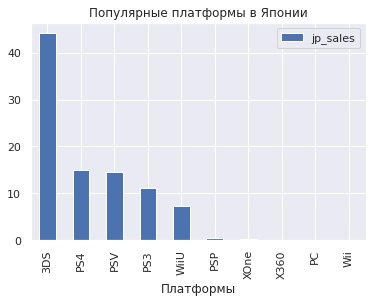

In [40]:
topical_period.pivot_table(
    index='platform', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales',ascending=False).plot(kind='bar');
plt.title('Популярные платформы в Японии');
plt.xlabel('Платформы');

**Топ 5 для Северной Америки:** PS4, XOne, X360, PS3, 3DS

**Топ 5 для Европы:** PS4, PS3, XOne, X360, 3DS

**Топ 5 для Японии:** 3DS, PS3, PSV, PS4, WiiU

В Америке и Европе топ платформ почти сходится, различие лишь в том что в европе больше предпочитают платформы компании SONY, в Америки же видна конкуренция компаний SONY и Microsoft. 

В Японии предпочитают отечественные платформы, при чём Nintendo в 3 раза популярнее SONY.

#### Самые популярные жанры

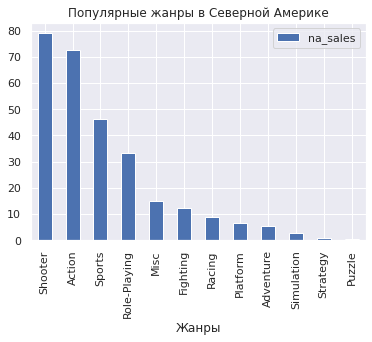

In [41]:
topical_period.pivot_table(
    index='genre', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales',ascending=False).plot(kind='bar');
plt.title('Популярные жанры в Северной Америке');
plt.xlabel('Жанры');

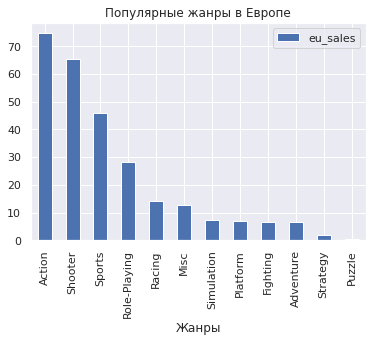

In [42]:
topical_period.pivot_table(
    index='genre', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales',ascending=False).plot(kind='bar');
plt.title('Популярные жанры в Европе');
plt.xlabel('Жанры');

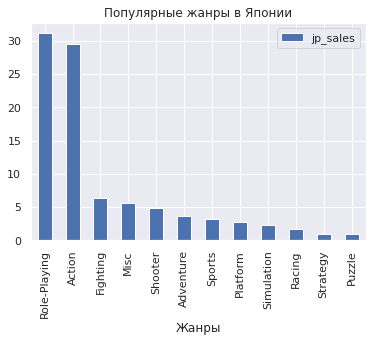

In [43]:
topical_period.pivot_table(
    index='genre', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales',ascending=False).plot(kind='bar');
plt.title('Популярные жанры в Японии');
plt.xlabel('Жанры');

**Топ 5 для Северной Америки:** Action, Shooter, Sports, Role-Playing, Misc

**Топ 5 для Европы:** Action, Shooter, Sports, Role-Playing, Racing

**Топ 5 для Японии:** Role-Playing, Action, Misc, Fighting, Shooter

В Америке и Европе предпочитают игры жанров экшен и шутер, можно соотнести это с платформами, ведь для SONY и Xbox большенство игр этих жанров. В Японии больше внимания уделяют ролевым играм и экшену. 

Если в Америке и Европе предпочтения практически совпадают, то Япония более самобытна в этом плане.

#### Влиягие рейтинга ESRB на продажи

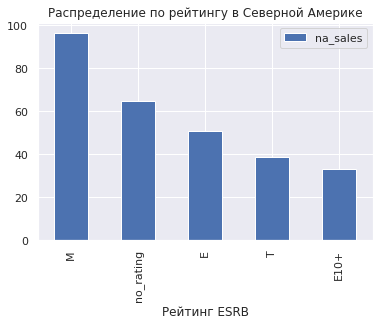

In [44]:
topical_period.pivot_table(
    index='rating', values='na_sales', aggfunc='sum').sort_values(
    by='na_sales',ascending=False).plot(kind='bar');
plt.title('Распределение по рейтингу в Северной Америке');
plt.xlabel('Рейтинг ESRB');

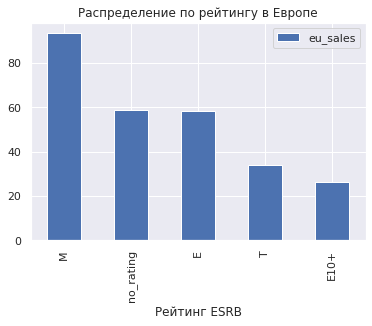

In [45]:
topical_period.pivot_table(
    index='rating', values='eu_sales', aggfunc='sum').sort_values(
    by='eu_sales',ascending=False).plot(kind='bar');
plt.title('Распределение по рейтингу в Европе');
plt.xlabel('Рейтинг ESRB');

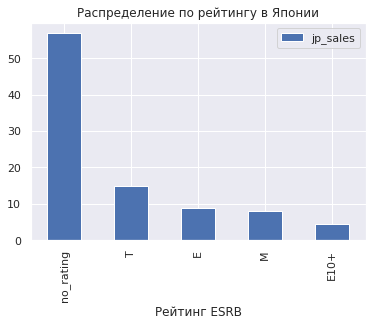

In [46]:
topical_period.pivot_table(
    index='rating', values='jp_sales', aggfunc='sum').sort_values(
    by='jp_sales',ascending=False).plot(kind='bar');
plt.title('Распределение по рейтингу в Японии');
plt.xlabel('Рейтинг ESRB');

ESRB - это организация, которая определяет рейтинги в США и Канаде. Исходя из этого рейтинг ESRB не влияет на продажи в Японии. В Америки и Европе опять же видим схожие графики, говорящие о том что больше продаются игры с рейтингом М - для врослых. 

В ходе составления портрета пользователя для каждого региона, мы убидились как же всё таки западная культура отличается от восточной даже в выборе игр и консолей.

### Проверка гипотез

**H0:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**H1:** Средние пользовательские рейтинги платформ Xbox One и PC разные

In [47]:
XOne = topical_period[(topical_period['platform'] == 'XOne') &  (topical_period['user_score'] > 0)]['user_score']
PC = topical_period[(topical_period['platform'] == 'PC') &  (topical_period['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг платформы Xbox One:', XOne.mean())
print('Средний пользовательский рейтинг платформы PC', PC.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.594545454545456
Средний пользовательский рейтинг платформы PC 6.298360655737705


In [48]:
alpha = .05

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


**H0:** Средние пользовательские рейтинги жанров Action и Sports одинаковые

**H1:** Средние пользовательские рейтинги жанров Action и Sports разные

In [49]:
Action = topical_period[(topical_period['genre'] == 'Action') &  (topical_period['user_score'] > 0)]['user_score']
Sports  = topical_period[(topical_period['genre'] == 'Sports') &  (topical_period['user_score'] > 0)]['user_score']
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.760606060606061
Средний пользовательский рейтинг жанра Sports 5.2251968503937


In [50]:
alpha = .05

results = st.ttest_ind(Action, Sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Нулевая гипотеза формулируется так, чтобы все данные лежали в районе изначально предполагаемого значения, а альтернативная гипотеза говорит от том, что данные лежат за пределами предполагаемого значение.

Проверив гипотезы мы подтверждаем, что:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Общий вывод

Нам были предоставлены данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности, для того чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

Для начала была произведена предобработка данных:
- привели названия столбцов к нижнему регистру;
- преобразовали данные в нужный тип;
- обработали пропуски;
- добавили столбец с суммарными продажами во всех регионах.

Затем, после всех совершенных действий, которые позволяют более точно и коректно оценивать данные, произвели анализ по которому можно сделать следущие выводы:
- За актуальный период (2013-2016гг) лидируют по продажам 5 платформ (PS4, PS3, XOne, 3DS, X360). PS4 и XOne пришли на замену PS3 и X360 и поэтому игр для этих платформ будут производить больше, соотвественно и продаж на них тоже будет больше. Можно считать эти платформы более перспективными для вдожений.
- Есть не большая зависимость между оценками критиков и продажами игр, но оценки критиков скорее влияют на выбор пользователей, которые в свою очередь покупают или не покупают игру.
- Западная и восточная культуры очень отличаются между собой, к каждой нужен свой подход. На западе чаще выбирают платформы от SONY и Xbox и игры жанра Action и Shooter, на востоке предпочитают Nintendo и Role-Playing. Так же стоит учитывать что рейтинг ESRB создан для США и Канады.